In [ ]:
!git clone https://github.com/sosamandara/token_reduction_nlp.git

Cloning into 'token_reduction_nlp'...
remote: Enumerating objects: 113, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 113 (delta 34), reused 92 (delta 19), pack-reused 0
Receiving objects: 100% (113/113), 2.81 MiB | 12.62 MiB/s, done.
Resolving deltas: 100% (34/34), done.


In [ ]:
%cd /content/token_reduction_nlp/notebooks

/content/token_reduction_nlp/notebooks


In [ ]:
import sys
import os

# Get the current working directory
current_dir = os.getcwd()

# Assuming the notebooks are in the notebooks directory and executed from there
project_root = os.path.abspath(os.path.join(current_dir, '..'))

# Add the models and src directories to the Python path
models_dir = os.path.join(project_root, 'models')
src_dir = os.path.join(project_root, 'src')

sys.path.append(models_dir)
sys.path.append(src_dir)

# Verify that the paths are correctly added
print("Current directory:", current_dir)
print("Project root directory:", project_root)
print("Models directory added to sys.path:", models_dir in sys.path)
print("Src directory added to sys.path:", src_dir in sys.path)

Current directory: /content/token_reduction_nlp/notebooks
Project root directory: /content/token_reduction_nlp
Models directory added to sys.path: True
Src directory added to sys.path: True


In [ ]:
!pip install datasets
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config, AutoTokenizer, AutoModel
from modeling_topK_gpt2 import CustomGPT2LMHeadModel
import json
from collections import defaultdict
import matplotlib.pyplot as plt
from datasets import load_dataset
from functions import run_generation_on_dataset, plot_averages
from perplexity import evaluate_perplexity_with_window, evaluate_and_save_perplexities, recalculate_and_plot_perplexities
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import torch
from tqdm import tqdm
import pandas as pd

In [ ]:
def calculate_reduction(lenght, mask):
  actual_lenght=lenght
  for percentage in mask:
    actual_lenght = (actual_lenght - int(actual_lenght*percentage))
  return actual_lenght + 1

window_sizes = [37, 50, 100, 200, 300, 500, 1000]
remaining_tokens = []
per_reduction = []
mask = [0.0, 0.0, 0.05, 0.07, 0.1, 0.07, 0.05, 0.0, 0.0, 0.05, 0.0, 0.0]
for w in window_sizes:
  remaining_tokens.append(calculate_reduction(w, mask))
  per_reduction.append(round(1-round(calculate_reduction(w, mask)/w,2),2))
print(remaining_tokens)
per_reduction

[28, 38, 71, 136, 204, 337, 670]


[0.24, 0.24, 0.29, 0.32, 0.32, 0.33, 0.33]

In [ ]:
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
config = GPT2Config.from_pretrained(model_name)
model_gpt = GPT2LMHeadModel.from_pretrained(model_name, config=config)
model_gpt.to('cuda')

#mask_25 25 is the total keep rate
mask_25 = [0.0, 0.0, 0.2, 0.2, 0.2, 0.15, 0.2, 0.2, 0.05, 0.05, 0.0, 0.05]
topK_25 = CustomGPT2LMHeadModel.from_pretrained(model_name, config=config, k_percent=mask_25,
                                                layers_to_prune=[0, 1, 2,3, 4, 5, 6,7,8,9,10,11])
topK_25.to('cuda')

########
mask_60 = [0.0, 0.0, 0.07, 0.07, 0.1, 0.07, 0.07, 0.05, 0.05, 0.05, 0.0, 0.0]
topK_60 = CustomGPT2LMHeadModel.from_pretrained(model_name, config=config, k_percent=mask_60,
                                                layers_to_prune=[0, 1, 2,3, 4, 5, 6,7,8,9,10,11])
topK_60.to('cuda')

mask_70 = [0.0, 0.0, 0.05, 0.07, 0.1, 0.07, 0.05, 0.0, 0.0, 0.05, 0.0, 0.0]
topK_70 = CustomGPT2LMHeadModel.from_pretrained(model_name, config=config, k_percent=mask_70,
                                                layers_to_prune=[0, 1, 2,3, 4, 5, 6,7,8,9,10,11])
topK_70.to('cuda')
########

mask_80 = [0.0, 0.0, 0.0, 0.05, 0.05, 0.05, 0.05, 0.05, 0.0, 0.0, 0.0, 0.0]
topK_80 = CustomGPT2LMHeadModel.from_pretrained(model_name, config=config, k_percent=mask_80,
                                                layers_to_prune=[0, 1, 2,3, 4, 5, 6,7,8,9,10,11])
topK_80.to('cuda')

mask_90 = [0.0, 0.0, 0.0, 0.05, 0.0, 0.05, 0.0, 0.03, 0.0, 0.0, 0.0, 0.0]
topK_90 = CustomGPT2LMHeadModel.from_pretrained(model_name, config=config, k_percent=mask_90,
                                                layers_to_prune=[0, 1, 2,3, 4, 5, 6,7,8,9,10,11])
topK_90.to('cuda')


In [ ]:
test = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")
encodings = tokenizer("\n\n".join(test["text"]), return_tensors="pt")

In [ ]:
window_sizes = [50, 100, 200, 300, 500, 1000]
models = [model_gpt, topK_25, topK_60, topK_70, topK_80, topK_90]
model_names = ['gpt2', 'topK_25', 'topK_60', 'topK_70', 'topK_80', 'topK_90']
output_dir = 'results'

evaluate_and_save_perplexities(models, model_names, encodings, window_sizes, output_dir)

# Load from results folder

Saved recalculated perplexities for gpt2 to /content/token_reduction_nlp/results/recalculated_perplexities_gpt2.csv
Saved recalculated perplexities for custom_25% to /content/token_reduction_nlp/results/recalculated_perplexities_custom_25%.csv
Saved recalculated perplexities for custom_60% to /content/token_reduction_nlp/results/recalculated_perplexities_custom_60%.csv
Saved recalculated perplexities for custom_70% to /content/token_reduction_nlp/results/recalculated_perplexities_custom_70%.csv
Saved recalculated perplexities for custom_80% to /content/token_reduction_nlp/results/recalculated_perplexities_custom_80%.csv
Saved recalculated perplexities for custom_90% to /content/token_reduction_nlp/results/recalculated_perplexities_custom_90%.csv


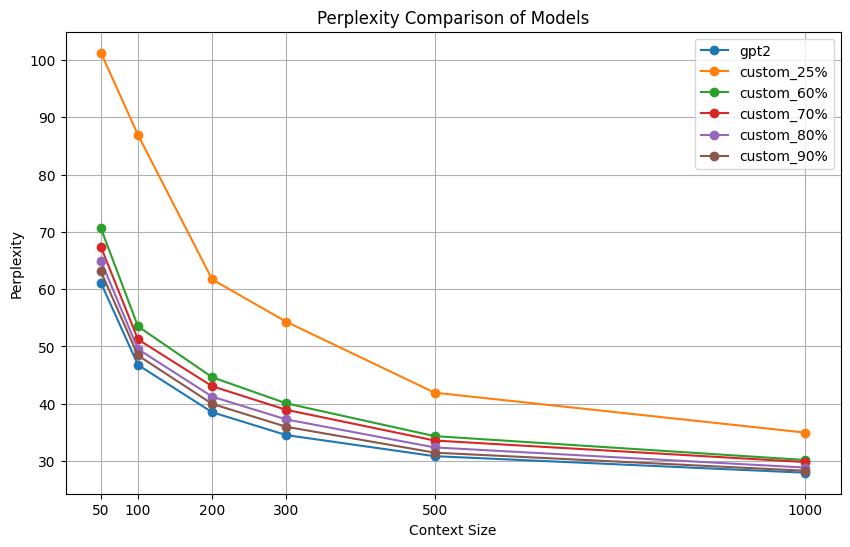

Recalculated perplexities and plot saved to /content/token_reduction_nlp/results


In [17]:
# Example usage
window_sizes = [50, 100, 200, 300, 500, 1000]
model_names = ['gpt2', 'custom_25%', 'custom_60%', 'custom_70%', 'custom_80%', 'custom_90%']
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
output_dir = os.path.join(project_root, 'results')

recalculate_and_plot_perplexities(window_sizes, model_names, output_dir)